# Predicting the Outcome of Cricket Matches

## Introduction

In this project, we shall build a model which predicts the outcome of cricket matches in the Indian Premier League using data about matches and deliveries.

### Data Mining:

  * Season : 2008 - 2015 (8 Seasons)
  * Teams : DD, KKR, MI, RCB, KXIP, RR, CSK (7 Teams)
  * Neglect matches that have inconsistencies such as No Result, Tie, D/L Method, etc.

### Features:

  * Average Batsman Rating (Strike Rate)
  * Average Bowler Rating (Wickets per Run)
  * Player of the Match Awards 
  * Previous Encounters - Win by runs, Win by Wickets 
  * Recent form
  
### Prediction Model

  * Logistic Regression using sci-kit learn
  
  

In [60]:
%matplotlib inline 
import numpy as np # imports a fast numerical programming library
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import sklearn
from __future__ import division

## Data Mining
  

In [33]:
# Reading in the data
allmatches = pd.read_csv("../data/matches.csv")
alldeliveries = pd.read_csv("../data/deliveries.csv")
allmatches.head(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN
5,6,2008,Jaipur,2008-04-21,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,normal,0,Rajasthan Royals,0,6,SR Watson,Sawai Mansingh Stadium,Aleem Dar,RB Tiffin,NaN
6,7,2008,Hyderabad,2008-04-22,Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,normal,0,Delhi Daredevils,0,9,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",IL Howell,AM Saheba,NaN
7,8,2008,Chennai,2008-04-23,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,normal,0,Chennai Super Kings,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",DJ Harper,GA Pratapkumar,NaN
8,9,2008,Hyderabad,2008-04-24,Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,3,YK Pathan,"Rajiv Gandhi International Stadium, Uppal",Asad Rauf,MR Benson,NaN
9,10,2008,Chandigarh,2008-04-25,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,normal,0,Kings XI Punjab,66,0,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Aleem Dar,AM Saheba,NaN


In [34]:
# Selecting Seasons 2008 - 2015
matches_seasons = allmatches.loc[allmatches['season'] != 2016]
deliveries_seasons = alldeliveries.loc[alldeliveries['match_id'] < 518]

In [35]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_teams = matches_seasons.loc[(matches_seasons['team1'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab'])) & (matches_seasons['team2'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab']))]
matches_teams.team1.unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
       'Delhi Daredevils'], dtype=object)

In [36]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_team_matchids = matches_teams.id.unique()
deliveries_teams = deliveries_seasons.loc[deliveries_seasons['match_id'].isin(matches_team_matchids)]
deliveries_teams.batting_team.unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Daredevils', 'Mumbai Indians'], dtype=object)

In [37]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches = matches_teams.loc[(matches_teams['result'] == 'normal') & (matches_teams['dl_applied'] == 0)]

In [38]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches_matchids = matches.id.unique()
deliveries = deliveries_teams.loc[deliveries_teams['match_id'].isin(matches_matchids)]

In [39]:
# Verifying consistency between datasets
(matches.id.unique() == deliveries.match_id.unique()).all()

True

## Building Features

In [40]:
# Batsman Strike Rate Calculation
# Team 1: Batting First; Team 2: Fielding First

def getMatchDeliveriesDF(match_id):
    return deliveries.loc[deliveries['match_id'] == match_id]

def getInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()[0:5]

def getInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()[0:5]

def getBatsmanStrikeRate(batsman, match_id):
    onstrikedeliveries = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['batsman'] == batsman)]
    total_runs = onstrikedeliveries['batsman_runs'].sum()
    total_balls = onstrikedeliveries.shape[0]
    if total_balls != 0: 
        return (total_runs/total_balls) * 100
    else:
        return None

def getTeamStrikeRate(batsmen, match_id):
    strike_rates = []
    for batsman in batsmen:
        bsr = getBatsmanStrikeRate(batsman, match_id)
        if bsr != None:
            strike_rates.append(bsr)
    return np.mean(strike_rates)

def getAverageStrikeRates(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getInningsTwoBatsmen(match_deliveries)
    teamOneSR = getTeamStrikeRate(innOneBatsmen, match_id)
    teamTwoSR = getTeamStrikeRate(innTwoBatsmen, match_id)
    return teamOneSR, teamTwoSR

In [41]:
# testing functionality
getAverageStrikeRates(517)

(126.98024523159935, 128.55579510411653)

In [42]:
# Bowler Rating : Wickets/Run (Higher the Better)
# Team 1: Batting First; Team 2: Fielding First

def getInningsOneBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()[0:4]

def getInningsTwoBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()[0:4]

def getBowlerWPR(bowler, match_id):
    balls = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['bowler'] == bowler)]
    total_runs = balls['total_runs'].sum()
    total_wickets = balls.loc[balls['dismissal_kind'].isin(['caught', 'bowled', 'lbw', \
    'caught and bowled', 'stumped'])].shape[0]
    if balls.shape[0] > 0:
        return (total_wickets/total_runs) * 100
    else:
        return None

def getTeamWPR(bowlers, match_id):
    WPRs = []
    for bowler in bowlers:
        bwpr = getBowlerWPR(bowler, match_id)
        if bwpr != None:
            WPRs.append(bwpr)
    return np.mean(WPRs)

def getAverageWPR(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBowlers = getInningsOneBowlers(match_deliveries)
    innTwoBowlers = getInningsTwoBowlers(match_deliveries)
    teamOneWPR = getTeamWPR(innTwoBowlers, match_id)
    teamTwoWPR = getTeamWPR(innOneBowlers, match_id)
    return teamOneWPR, teamTwoWPR

In [43]:
# testing functionality
getAverageWPR(517)

(2.7641806594085776, 4.4721111768026631)

In [44]:
# MVP Score
# Team 1: Batting First; Team 2: Fielding First

def getAllInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()

def getAllInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()

def getAllInningsOneBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()

def getAllInningsTwoBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()

def makeSquad(batsmen, bowlers):
    p = []
    p = np.append(p, batsmen)
    for i in bowlers:
        if i not in batsmen:
            p = np.append(p, i)
    return p

def getPlayerMVPAwards(player, match_id):
    return matches.loc[(matches['player_of_match'] == player) & (matches['id'] < match_id)].shape[0]

def getTeamMVPAwards(squad, match_id):
    num_awards = 0
    for player in squad:
        num_awards += getPlayerMVPAwards(player, match_id)
    return num_awards

def compareMVPAwards(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getAllInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getAllInningsTwoBatsmen(match_deliveries)
    innOneBowlers = getAllInningsOneBowlers(match_deliveries)
    innTwoBowlers = getAllInningsTwoBowlers(match_deliveries)
    teamOneSquad = makeSquad(innOneBatsmen, innTwoBowlers)
    teamTwoSquad = makeSquad(innTwoBatsmen, innOneBowlers)
    teamOneAwards = getTeamMVPAwards(teamOneSquad, match_id)
    teamTwoAwards = getTeamMVPAwards(teamTwoSquad, match_id)
    return teamOneAwards, teamTwoAwards

In [45]:
compareMVPAwards(517)

(28, 52)

In [46]:
def generateSquadRating(match_id):
    gameday_teams = deliveries.loc[(deliveries['match_id'] == match_id)].batting_team.unique()
    teamOne = gameday_teams[0]
    teamTwo = gameday_teams[1]
    teamOneSR, teamTwoSR = getAverageStrikeRates(match_id)
    teamOneWPR, teamTwoWPR = getAverageWPR(match_id)
    teamOneMVPs, teamTwoMVPs = compareMVPAwards(match_id)
    print "Comparing squads for " + teamOne + " vs " + teamTwo
    print "\nAverage Strike Rate for Batsmen in " + str(teamOne) + " : " + str(teamOneSR)
    print "\nAverage Strike Rate for Batsmen in " + str(teamTwo) + " : " + str(teamTwoSR)
    print "\nBowler Rating for " + str(teamOne) + " : " + str(teamOneWPR)
    print "\nBowler Rating for " + str(teamTwo) + " : " + str(teamTwoWPR)
    print "\nNumber of MVP Awards in " + str(teamOne) + " : " + str(teamOneMVPs)
    print "\nNumber of MVP Awards in " + str(teamTwo) + " : " + str(teamTwoMVPs)

In [47]:
generateSquadRating(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating for Mumbai Indians : 2.76418065941

Bowler Rating for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 28

Number of MVP Awards in Chennai Super Kings : 52


In [48]:
# Previous Encounters
# Won by runs and won by wickets (Higher the better)

def getTeam1(match_id):
    return matches.loc[matches["id"] == match_id].team1.unique()

def getTeam2(match_id):
    return matches.loc[matches["id"] == match_id].team2.unique()

def getPreviousEncDF(match_id):
    team1 = getTeam1(match_id)
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (((matches["team1"].isin(team1)) & (matches["team2"].isin(team2))) | ((matches["team1"].isin(team2)) & (matches["team2"].isin(team1))))].tail(8)

def getTeamWBR(match_id, team):
    WBR = 0
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBR = winnerDF['win_by_runs'].sum()    
    return WBR


def getTeamWBW(match_id, team):
    WBW = 0 
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBW = winnerDF['win_by_wickets'].sum()
    return WBW 
    
def getTeamWinPerc(match_id):
    dF = getPreviousEncDF(match_id)
    timesPlayed = dF.shape[0]
    team1 = getTeam1(match_id)[0].strip("[]")
    timesWon = dF.loc[dF["winner"] == team1].shape[0]
    if timesPlayed != 0:
        winPerc = (timesWon/timesPlayed) * 100
    else:
        winPerc = 0
    return winPerc

def getBothTeamStats(match_id):
    DF = getPreviousEncDF(match_id)
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    timesPlayed = DF.shape[0]
    timesWon = DF.loc[DF["winner"] == team1].shape[0]
    WBRTeam1 = getTeamWBR(match_id, team1)
    WBRTeam2 = getTeamWBR(match_id, team2)
    WBWTeam1 = getTeamWBW(match_id, team1)
    WBWTeam2 = getTeamWBW(match_id, team2)

    print "Out of {} times in the past {} have won {} times({}%) from {}".format(timesPlayed, team1, timesWon, getTeamWinPerc(match_id), team2)
    print "{} won by {} total runs and {} total wickets.".format(team1, WBRTeam1, WBWTeam1)
    print "{} won by {} total runs and {} total wickets.".format(team2, WBRTeam2, WBWTeam2)


In [49]:
#Testing functionality 
getBothTeamStats(517)

Out of 8 times in the past Mumbai Indians have won 3 times(37.5%) from Chennai Super Kings
Mumbai Indians won by 48 total runs and 6 total wickets.
Chennai Super Kings won by 48 total runs and 24 total wickets.


In [50]:
# Recent Form (Win Percentage of all the previous matches of a team in the same season)
# Higher the better

def getMatchYear(match_id):
    return matches.loc[matches["id"] == match_id].season.unique()

def getTeam1DF(match_id, year):
    team1 = getTeam1(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team1)) | (matches["team2"].isin(team1)))]

def getTeam2DF(match_id, year):
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team2)) | (matches["team2"].isin(team2)))]

def getTeamWinPercentage(match_id):
    year = int(getMatchYear(match_id))
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    team1DF = getTeam1DF(match_id, year)
    team2DF = getTeam2DF(match_id, year)
    team1TotalMatches = team1DF.shape[0]
    team1WinMatches = team1DF.loc[team1DF["winner"] == team1].shape[0]
    team2TotalMatches = team2DF.shape[0]
    team2WinMatches = team2DF.loc[team2DF["winner"] == team2].shape[0]
    winPercTeam1 = (team1WinMatches / team1TotalMatches) * 100
    winPercTeam2 = (team2WinMatches / team2TotalMatches) * 100
    print "In the season of {}, {} has a win percentage of {}% and {} has a win percentage of {}% ".format(year, team1, winPercTeam1, team2, winPercTeam2)
    

In [51]:
getTeamWinPercentage(517)

In the season of 2015, Mumbai Indians has a win percentage of 53.8461538462% and Chennai Super Kings has a win percentage of 64.2857142857% 


In [52]:
#Function to implement all features
def getAllFeatures(match_id):
    generateSquadRating(match_id)
    print ("\n")
    getBothTeamStats(match_id)
    print("\n")
    getTeamWinPercentage(match_id)


In [53]:
#Testing Functionality
getAllFeatures(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating for Mumbai Indians : 2.76418065941

Bowler Rating for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 28

Number of MVP Awards in Chennai Super Kings : 52


Out of 8 times in the past Mumbai Indians have won 3 times(37.5%) from Chennai Super Kings
Mumbai Indians won by 48 total runs and 6 total wickets.
Chennai Super Kings won by 48 total runs and 24 total wickets.


In the season of 2015, Mumbai Indians has a win percentage of 53.8461538462% and Chennai Super Kings has a win percentage of 64.2857142857% 


## Adding New Columns for Features in Matches DataFrame

In [54]:
# New Column for Difference of Average Strike rates (First Team SR - Second Team SR) 
# [Negative value means Second team is better]

firstTeamSR = []
secondTeamSR = []
for i in matches['id'].unique():
    P, Q = getAverageStrikeRates(i)
    firstTeamSR.append(P), secondTeamSR.append(Q)
firstSRSeries = pd.Series(firstTeamSR)
secondSRSeries = pd.Series(secondTeamSR)
matches["Avg_SR_Difference"] = firstSRSeries.values - secondSRSeries.values 

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
# New Column for Difference of Wickets Per Run (First Team WPR - Second Team WPR) 
# [Negative value means Second team is better]

firstTeamWPR = []
secondTeamWPR = []
for i in matches['id'].unique():
    R, S = getAverageWPR(i)
    firstTeamWPR.append(R), secondTeamWPR.append(S)
firstWPRSeries = pd.Series(firstTeamWPR)
secondWPRSeries = pd.Series(secondTeamWPR)
matches["Avg_WPR_Difference"] = firstWPRSeries.values - secondWPRSeries.values 

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
# New column for difference of MVP Awards 
# (Negative value means Second team is better)

firstTeamMVP = []
secondTeamMVP = []
for i in matches['id'].unique():
    T, U = compareMVPAwards(i)
    firstTeamMVP.append(T), secondTeamMVP.append(U)
firstMVPSeries = pd.Series(firstTeamMVP)
secondMVPSeries = pd.Series(secondTeamMVP)
matches["Total_MVP_Difference"] = firstMVPSeries.values - secondMVPSeries.values 

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
# New column for Win Percentage of Team 1 in previous encounters

firstTeamWP = []
for i in matches['id'].unique():
    WP = getTeamWinPerc(i)
    firstTeamWP.append(WP)
firstWPSeries = pd.Series(firstTeamWP)
matches["Prev_Enc_Team1_WinPerc"] = firstWPSeries.values

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
#Create Column for Team 1 Winning Status (1 = Won, 0 = Lost)

matches['team1Winning'] = np.where(matches['team1'] == matches['winner'], 1, 0)

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [59]:
#Testing 
matches.tail()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,Avg_SR_Difference,Avg_WPR_Difference,Total_MVP_Difference,Prev_Enc_Team1_WinPerc,team1Winning
510,511,2015,Mumbai,2015-05-16,Rajasthan Royals,Kolkata Knight Riders,Rajasthan Royals,bat,normal,0,Rajasthan Royals,9,0,SR Watson,Brabourne Stadium,RM Deshpande,RK Illingworth,NaN,-3.303823,-0.271935,-16,37.5,1
513,514,2015,Mumbai,2015-05-19,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Mumbai Indians,25,0,KA Pollard,Wankhede Stadium,HDPK Dharmasena,RK Illingworth,NaN,6.315981,-0.617777,-24,37.5,1
514,515,2015,Pune,2015-05-20,Royal Challengers Bangalore,Rajasthan Royals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,71,0,AB de Villiers,Maharashtra Cricket Association Stadium,AK Chaudhary,C Shamshuddin,NaN,-2.200375,0.969143,5,50.0,1
515,516,2015,Ranchi,2015-05-22,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,3,A Nehra,JSCA International Stadium Complex,AK Chaudhary,CB Gaffaney,NaN,-0.521025,1.039181,-23,25.0,0
516,517,2015,Kolkata,2015-05-24,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,field,normal,0,Mumbai Indians,41,0,RG Sharma,Eden Gardens,HDPK Dharmasena,RK Illingworth,NaN,-1.575550,-1.707931,-24,37.5,1


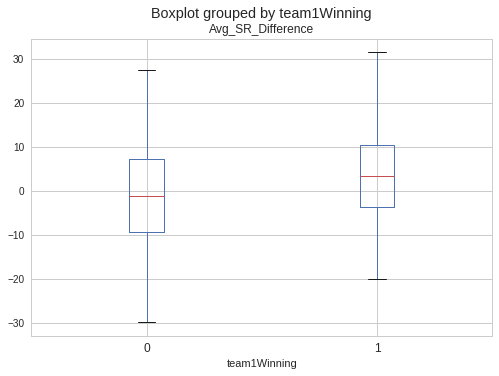

In [69]:
matches.boxplot(column = 'Avg_SR_Difference', by='team1Winning', showfliers= False)

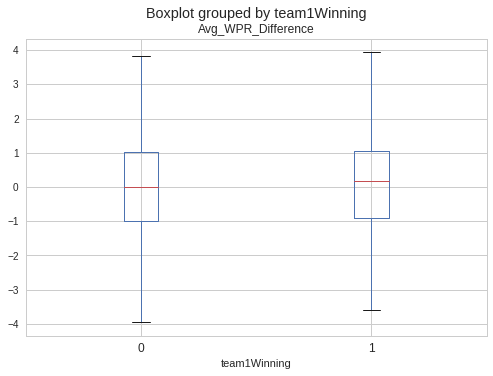

In [64]:
matches.boxplot(column = 'Avg_WPR_Difference', by='team1Winning', showfliers= False)

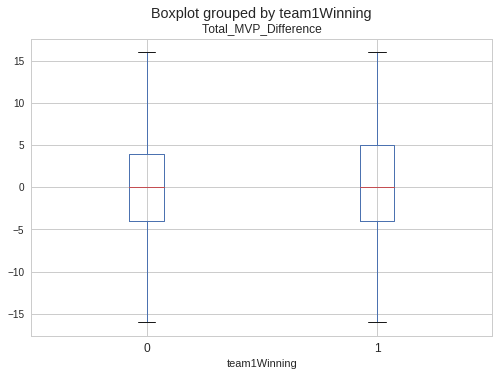

In [65]:
matches.boxplot(column = 'Total_MVP_Difference', by='team1Winning', showfliers= False)

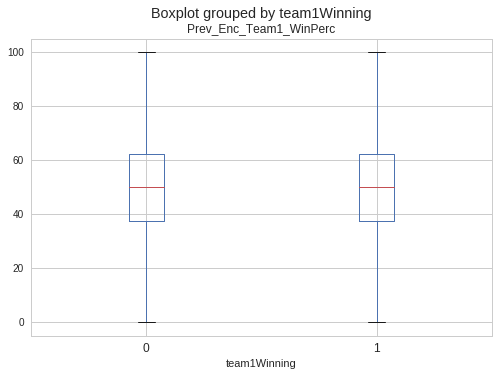

In [74]:
matches.boxplot(column = 'Prev_Enc_Team1_WinPerc', by='team1Winning', showfliers= False)